# 一、爬虫

In [207]:
# %load guba_crawl_topic.py
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 23 2018

爬取东方财富网股吧-热门主题吧
数据文件采用csv存取
"""

import requests
from bs4 import BeautifulSoup
import csv
import time

# 获取页面内容
def getHTMLText(url):
    try:
        r = requests.get(url)
        r.raise_for_status()
        r.encoding = r.apparent_encoding
        return r.text
    except:
        return ""

# 这里比较m_time是否大于n_time
def compare_time(m_time,n_time):
    m_time1 = time.mktime(time.strptime(m_time,'%Y-%m-%d %H:%M:%S')) 
    n_time1 = time.mktime(time.strptime(n_time,'%Y%m%d'))
    if (float(m_time1) >= float(n_time1)):
        return 1
    else:
        return 0

# 爬取热门主题吧：主题 + 网页链接
'''
    财经评论
    http://guba.eastmoney.com/list,cjpl,99_1.html
    http://guba.eastmoney.com/list,cjpl,99_2.html ...
'''
def hot_zhutiba(topic_list):
    html = getHTMLText("http://guba.eastmoney.com/remenba.aspx?type=2")    #该网址为股吧热门主题吧列表
    soup = BeautifulSoup(html,'html.parser') # 解析网页
    a1 = soup.find("div",attrs={"class":"zhutibarlist"})    #body > div:nth-child(6) > div.gbboxb > div > ul > ul > li:nth-child(1) > a
    a2 = a1.find_all("a")                                   #热门主题吧："class":"zhutibarlist"
    one = []                                                #全部主题吧："class":"allzhutilistb"
    for tr in a2:
        title = tr.text # 主题吧 名称
        href = tr.attrs["href"] # list,cjpl.html
        href = href.split('.')[0].split(",")[1] # 主题吧热贴 http://guba.eastmoney.com/list,cjpl,99.html
        one.append(title)                       #
        one.append(href)
        topic_list.append(one)
        # file = "./py_project/stock_crawl_new/topic.csv"
        # with open(file, 'a', newline="") as f:
        #     #dialect为打开csv文件的方式，默认是excel，delimiter="\t"参数指写入的时候的分隔符
        #     csvwriter = csv.writer(f,dialect = ("excel"))
        #     #csv文件插入一行数据，把下面列表中的每一项放入一个单元格（可以用循环插入多行）
        #     csvwriter.writerow(one)
        one = []
    return topic_list
'''
[[['财经评论吧', 'cjpl'], ['股市实战吧', 'gssz'], ['上证指数吧', 'szzs'], ['玉米吧', 'fdcec'], 
 ['螺纹钢吧', 'fshferb'], ['铁矿石吧', 'fdcei'], ['房地产吧', 'fdc'], ['焦炭主力吧', 'fdcejm'], 
 ['股民学校吧', 'gmxx'], ['新三板吧', 'bk0600'], ['沪金吧', 'fshfeau'], ['焦炭吧', 'fdcej'], 
 ['美元指数吧', 'zsgjudi'], ['核心内参吧', 'hxnc'], ['股指期货吧', 'gzqh'], ['创业板指吧', 'cyb'], 
 ['甲醇吧', 'fczcema'], ['橡胶吧', 'fshferu'], ['原油吧', 'yuanyou'], ['恒生指数吧', 'hkhsi'], 
 ['现货吧', 'xianhuo'], ['大话财经吧', 'dhcj'], ['新股吧', 'xg'], ['玻璃吧', 'fczcefg'], 
 ['豆粕吧', 'fdcem'], ['理财吧', 'licai'], ['白糖单吧', 'fczcesr'], ['PTA吧', 'fczceta'], 
  ['沪银吧', 'fshfeag'], ['期货吧', 'qh']]]
'''

# 获取评论的发表时间，内容
def getCommentContent(url):
    publish_time,content = "",""
    html = getHTMLText(url) # [url]"http://guba.eastmoney.com/news,cjpl,746982237.html"
    soup = BeautifulSoup(html,'html.parser')
    # title = soup.title.text.split("_")[0] # 标题
    a = soup.find("div",attrs={"id":"zwconbody"})
    # a1 = a.find("div",attrs={"id":"zw_header"})
    # come_from = a1.text.split(" ")[0].split("：")[1] # 来源
    # b1 = a.find("div",attrs={"id":"zw_body"})
    # b = a.find_all("p")
    # for tr in b:
    #     content = content + tr.text # 内容
    # content = a.text
    if a != None:
        try:      
            for string in a.stripped_strings:
                content = content + string
        except:        
            content = content + a.string
    else:
        content = "wrong"
    c = soup.find("div",attrs={"class":"zwfbtime"})
    try:
        publish_time = c.text.split(" ")[1] + " " + c.text.split(" ")[2] # 发表时间 发表于 2018-02-24 08:42:00
    except:
        publish_time = c.text.split(" ")[0].split("：")[1] + " " + c.text.split(" ")[1] # 发表于：2018-02-26 10:53:04
    return publish_time,content

# 获取评论信息
def getCommentInfo(start_url,file,page,start,end,topic_bar,topic_url):
    flag = 1
    html = getHTMLText(start_url) # 热帖开始网址 http://guba.eastmoney.com/list,cjpl,99.html
    soup = BeautifulSoup(html,'html.parser')
    # header
    # a1 = soup.find("div",attrs={"class":"dheader"})
    # header_list = [] # ['阅读', '评论', '标题', '作者', '发表日期', '最后更新']
    # a2 = a1.find_all("span")
    # for tr in a2:
    #     header = tr.text
    #     header_list.append(header)
    # # 获取帖子['阅读', '评论', '标题', '作者', '发表日期', '最后更新']
    Oneinfo = []
    count = 0
    b1 = soup.find_all("div",attrs={"class":"articleh"})
    if b1 != None:
        for tr in b1:
            t1 = time.time()
            count = count + 1
            read_num = tr.find("span",attrs={"class":"l1"}).text
            comment_num = tr.find("span",attrs={"class":"l2"}).text
            title = tr.find("span",attrs={"class":"l3"}).text
            content_url = "http://guba.eastmoney.com" + tr.find("span",attrs={"class":"l3"}).a.attrs["href"]
            publish_time,content = getCommentContent(content_url)
            author = tr.find("span",attrs={"class":"l4"}).text
            # publish_time = tr.find("span",attrs={"class":"l5"}).text # 没有年份
            # latest_time = tr.find("span",attrs={"class":"l6"}).text

            # 根据发帖时间判断是否需要爬取下一页以及是否需要爬取帖子标题和内容
            time_fit1 = compare_time(publish_time,start) # > :1 晚 else:0 早
            time_fit2 = compare_time(publish_time,end)   # > :1 晚 else:0 早

            # 当前帖子的发帖时间小于爬取开始时间，不需要继续爬取下一页评论列表，设置flag=0
            if time_fit1 == 0:
                flag = 0
            else:
                flag = 1

            #当前帖子的发帖时间处于爬取时间段内，对帖子标题和内容进行爬取
            if time_fit1 == 1 and time_fit2 == 0:
                Oneinfo.append(["page_"+str(page),count]) # 页面信息
                Oneinfo.append(title) # 评论标题
                Oneinfo.append(author) # 发表作者
                Oneinfo.append(publish_time) # 发表时间
                Oneinfo.append(read_num) # 阅读量
                Oneinfo.append(comment_num) # 评论量
                Oneinfo.append(content_url) # 内容链接: http://guba.eastmoney.com/news,cjpl,743193430.html
                Oneinfo.append(content) # 评论内容
                # Oneinfo.append(latest_time) # 最后更新时间
                with open(file, 'a', newline="", encoding='gb18030') as f: # ,encoding="gb18030"
                    # dialect为打开csv文件的方式，默认是excel，delimiter="\t"参数指写入的时候的分隔符
                    csvwriter = csv.writer(f,dialect = ("excel"))
                    # csv文件插入一行数据，把下面列表中的每一项放入一个单元格（可以用循环插入多行）
                    csvwriter.writerow(Oneinfo)
                t2 = time.time()
                print(topic_bar,"p"+str(page),count,"In and Crawling success,time using %.5f s" %(t2-t1))
                Oneinfo = []
            else:
                print(topic_bar,"p"+str(page),count,"Out")
    else:
        flag = 0

    if flag == 1:
        return "http://guba.eastmoney.com/list," + topic_url + ",99,f_" + str(page+1) + ".html"  
    else:
        return ""

    '''                 
    <span class="l1">14462545</span>
    <span class="l2">231</span>
    <span class="l3"><a href="/news,cjpl,743193430.html" title="1分钟股票开户立享多重惊喜：超低佣金，另有5大豪礼等你拿！" >1分钟股票开户立享多重惊喜：超低佣金，另有5大</a></span>
    <span class="l4"><a href="http://iguba.eastmoney.com/6712111507146464"  data-popper="6712111507146464" data-poptype="1" target="_blank">东方财富网</a><input type="hidden" value="31000" /><a href=" http://v2.eastmoney.com"><em class="lv" title="东方财富机构认证"></em></a></span>
    <span class="l6">01-25</span>
    <span class="l5">02-24 12:12</span>
    '''

#主函数
def main():   
    topic_list = []
    hot_zhutiba(topic_list) # 获取主题吧名称 链接
    start = '20180719'  # 设置爬取开始时间
    end = '20180721'  # 设置爬取结束时间,不包含此日

    time1 = time.time()
    for i in range(0,1): # len(topic_list)
        time3 = time.time()
        page = 1  # 财经评论吧 page42-49 即发表于2月27日 + 2月28日 的全部评论 
        # 2016:2525[2550 4]/2482/2435/2360/2264/2179/2109/2038/1980/
        # 2017:1935[start 1]/1887/1828/1769/1703/1644/1559/1419/1137/
        # [2017.10]925/608/323/
        # 2018:152/68/
        topic_bar = topic_list[i][0]
        topic_url = topic_list[i][-1]
        file = "D:\\Program Files\\Git\\git_work\\guba-topic-model-report\\" + 'cjpl_' + start + "_" + end + ".csv"        #设置评论内容的存储路径 
        start_url = "http://guba.eastmoney.com/list," + topic_url + ",99,f_" + str(page) + ".html"
        # http://guba.eastmoney.com/list,cjpl,99_1.html   按评论时间排序
        # http://guba.eastmoney.com/list,cjpl,99,f_1.html 按发帖时间排序
        print("------------------- Start Crawl -------------------")
        with open(file, 'a', newline="", encoding='gb18030') as f:
            csvwriter = csv.writer(f,dialect = ("excel"))
            csvwriter.writerow(["页面信息","评论标题","发表作者","发表时间","阅读量","评论量","内容链接","评论内容"])
        while True: 
            if start_url != "":              
                start_url = getCommentInfo(start_url,file,page,start,end,topic_bar,topic_url)        
                page = page + 1
            else:
                print("已完成topic " + topic_bar + " " + start + "-" + end + "的评论爬取")
                break
        time4 = time.time()
        m, s = divmod(time4-time3, 60)
        h, m = divmod(m, 60)
        print("topic " + topic_bar + " all time using %02d:%02d:%02d" % (h, m, s))
        print("------------------- End   Crawl -------------------")
        time2 = time.time()
        m, s = divmod(time2-time1, 60)
        h, m = divmod(m, 60)
        print ("all time using %02d:%02d:%02d" % (h, m, s))

main()

------------------- Start Crawl -------------------
财经评论吧 p1 1 In and Crawling success,time using 1.08563 s
财经评论吧 p1 2 In and Crawling success,time using 0.77117 s
财经评论吧 p1 3 In and Crawling success,time using 0.81883 s
财经评论吧 p1 4 In and Crawling success,time using 0.89619 s
财经评论吧 p1 5 In and Crawling success,time using 0.62958 s
财经评论吧 p1 6 In and Crawling success,time using 0.69579 s
财经评论吧 p1 7 In and Crawling success,time using 0.88215 s
财经评论吧 p1 8 In and Crawling success,time using 0.99779 s
财经评论吧 p1 9 In and Crawling success,time using 0.58875 s
财经评论吧 p1 10 In and Crawling success,time using 0.60884 s
财经评论吧 p1 11 In and Crawling success,time using 0.65050 s
财经评论吧 p1 12 In and Crawling success,time using 0.70441 s
财经评论吧 p1 13 In and Crawling success,time using 1.96301 s
财经评论吧 p1 14 In and Crawling success,time using 0.59924 s
财经评论吧 p1 15 In and Crawling success,time using 0.59081 s
财经评论吧 p1 16 In and Crawling success,time using 0.57033 s
财经评论吧 p1 17 In and Crawling success,time usin

财经评论吧 p2 65 In and Crawling success,time using 0.58333 s
财经评论吧 p2 66 In and Crawling success,time using 0.64309 s
财经评论吧 p2 67 In and Crawling success,time using 0.99197 s
财经评论吧 p2 68 In and Crawling success,time using 0.53323 s
财经评论吧 p2 69 In and Crawling success,time using 0.82350 s
财经评论吧 p2 70 In and Crawling success,time using 0.64959 s
财经评论吧 p2 71 In and Crawling success,time using 0.57365 s
财经评论吧 p2 72 In and Crawling success,time using 0.62389 s
财经评论吧 p2 73 In and Crawling success,time using 0.66072 s
财经评论吧 p2 74 In and Crawling success,time using 0.91051 s
财经评论吧 p2 75 In and Crawling success,time using 0.77272 s
财经评论吧 p2 76 In and Crawling success,time using 0.73504 s
财经评论吧 p2 77 In and Crawling success,time using 0.69205 s
财经评论吧 p2 78 In and Crawling success,time using 0.77974 s
财经评论吧 p2 79 In and Crawling success,time using 0.58194 s
财经评论吧 p2 80 In and Crawling success,time using 0.67799 s
财经评论吧 p3 1 In and Crawling success,time using 0.57902 s
财经评论吧 p3 2 In and Crawling succe

# 二、读入数据

In [386]:
import time
import pandas as pd
import numpy as np
from collections import Counter

In [387]:
df = pd.read_csv('cjpl_20180719_20180721.csv',
                 encoding='gb18030',
                 usecols=[1, 3, 7],
                 header=0,
                 names=['title', 'time', 'comment'])
df.head()

,title,time,comment
0,早盘内参：外管局称外国投资者持股不足3% 未来,2018-07-20 08:25:38,来源：东方财富网每日精选1、证券时报：财政部国库司总会计师王建勋表示，今年以来，积极的财政政...
1,长飞光纤今日上市 定位分析,2018-07-20 08:16:32,"来源：证券时报网 编辑：东方财富网长飞光纤今日上市。该公司A股股本为40,633.8314万..."
2,外资私募也被A股割韭菜？富达旗下股票基金今年,2018-07-20 08:03:55,来源：每日经济新闻 作者：刘海军 编辑：东方财富网前几天，贝莱德开始发行了首只私募基金产品—...
3,年初说好的“美股崩盘、A股崛起”呢？买啥才能,2018-07-20 08:02:54,来源：东方财富网 作者：十字路口2018年年初，有观点认为“美股下跌风险较大，而A股走势较乐...
4,人民日报、中消协点名批评 华帝股份凌晨回应称,2018-07-20 07:54:05,来源：东方财富网人民日报、中消协点名批评，华帝股份凌晨回应称履行承诺。华帝股份凌晨微博发文称...


In [388]:
df.shape

(246, 3)

# 三、对数据时间属性的刻画

In [389]:
# example attribute: data type of each column
df.dtypes

title      object
time       object
comment    object
dtype: object

In [390]:
df['time'] = pd.to_datetime(df.time, errors='ignore')

In [391]:
df.dtypes

title              object
time       datetime64[ns]
comment            object
dtype: object

In [392]:
df.time.dt.hour.head()

0    8
1    8
2    8
3    8
4    7
Name: time, dtype: int64

In [393]:
df.time.dt.dayofyear.head()

0    201
1    201
2    201
3    201
4    201
Name: time, dtype: int64

In [394]:
ts1 = pd.to_datetime('2018/7/19 15:00')
ts2 = pd.to_datetime('2018/7/20 9:00')
df = df.loc[df.time >= ts1, :]
df = df.loc[df.time <= ts2, :]

In [395]:
df.time.min()

Timestamp('2018-07-19 15:02:15')

In [396]:
df.time.max()

Timestamp('2018-07-20 08:25:38')

In [397]:
(df.time.max() - df.time.min()).days

0

In [398]:
%matplotlib inline

In [399]:
df['hour'] = df.time.dt.hour
df.hour.value_counts().sort_index()

0      7
1      3
4      1
5      7
6      5
7      3
8      4
15    14
16    14
17     9
18     2
19    14
20    14
21     6
22     5
Name: hour, dtype: int64

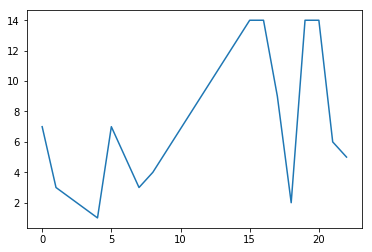

In [400]:
df.hour.value_counts().sort_index().plot()

# 四、中文分词

In [401]:
df.shape

(108, 4)

In [402]:
X = df.loc[:, ['comment']]

In [403]:
X.shape

(108, 1)

In [404]:
X.head()

,comment
0,来源：东方财富网每日精选1、证券时报：财政部国库司总会计师王建勋表示，今年以来，积极的财政政...
1,"来源：证券时报网 编辑：东方财富网长飞光纤今日上市。该公司A股股本为40,633.8314万..."
2,来源：每日经济新闻 作者：刘海军 编辑：东方财富网前几天，贝莱德开始发行了首只私募基金产品—...
3,来源：东方财富网 作者：十字路口2018年年初，有观点认为“美股下跌风险较大，而A股走势较乐...
4,来源：东方财富网人民日报、中消协点名批评，华帝股份凌晨回应称履行承诺。华帝股份凌晨微博发文称...


In [405]:
X.dtypes

comment    object
dtype: object

In [406]:
X.comment.describe()

count                                                   108
unique                                                  108
top       来源：新华网 编辑：东方财富网一些美国企业正在斥巨资回购股票。投资者认为，这一现象显现高级主...
freq                                                      1
Name: comment, dtype: object

In [407]:
import jieba
def chinese_word_cut(mytext):
    return ' '.join(jieba.cut(mytext))

In [408]:
# 加载专业词库，避免专业词汇被切分
jieba.load_userdict("userdict.txt")

In [409]:
%%time
X['cutted_comment'] = X.comment.apply(chinese_word_cut)

Wall time: 1.1 s


In [410]:
X.cutted_comment.head()

0    来源 ： 东方财富网 每日 精选 1 、 证券时报 ： 财政部 国库 司 总会计师 王建 勋...
1    来源 ： 证券时报网   编辑 ： 东方财富网 长飞 光纤 今日上市 。 该 公司 A股 股...
2    来源 ： 每日经济新闻   作者 ： 刘海军   编辑 ： 东方财富网 前 几天 ， 贝 莱...
3    来源 ： 东方财富网   作者 ： 十字路口 2018 年 年初 ， 有 观点 认为 “ 美...
4    来源 ： 东方财富网 人民日报 、 中消协 点名 批评 ， 华帝股份 凌晨 回应 称 履行 ...
Name: cutted_comment, dtype: object

In [411]:
X.shape

(108, 2)

In [412]:
def get_custom_stopwords(stop_words_file):
    with open(stop_words_file, encoding='utf-8') as f:
        stopwords = f.read( )
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

In [413]:
# 加载停用词表，并获取停用词
stop_words_file = 'mystopwords.txt'
stopwords = get_custom_stopwords(stop_words_file)

In [414]:
stopwords[-10:]

['背后', '医疗', '五大', '作用', '债市', '方案', '主力', '巨头', '东方财富网', '东方财富']

In [415]:
# 读入CountVectorizer向量化工具，它依据词语出现频率转化向量。
from sklearn.feature_extraction.text import CountVectorizer

In [416]:
vect = CountVectorizer()

In [417]:
# 用向量化工具转换已经分词的X.cutted_comment，并且将其转化为一个数据框
term_matrix = pd.DataFrame(vect.fit_transform(X.cutted_comment).toarray(), columns=vect.get_feature_names())
term_matrix.head()

,00,000,000002,000046,000063,000651,000671,000732,000760,000768,...,鼓励,鼓吹,龍哥,龙头,龙头企业,龙头股,龙源,龙虎榜,龚宇,龚梦泽
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,23,2,10,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [418]:
term_matrix.shape

(108, 9620)

In [419]:
vect = CountVectorizer(stop_words=frozenset(stopwords)) # 加上停用词去除功能

In [420]:
term_matrix = pd.DataFrame(vect.fit_transform(X.cutted_comment).toarray(), columns=vect.get_feature_names())
term_matrix.head()

,00,000,000002,000046,000063,000651,000671,000732,000760,000768,...,鼓励,鼓吹,龍哥,龙头,龙头企业,龙头股,龙源,龙虎榜,龚宇,龚梦泽
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,23,2,10,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [421]:
max_df = 0.8 # 在超过这一比例的文档中出现的关键词（过于平凡），去除掉。
min_df = 3 # 在低于这一数量的文档中出现的关键词（过于独特），去除掉。

In [422]:
vect = CountVectorizer(max_df=max_df,
                      min_df=min_df,
                      token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b',#去掉数字作为特征
                      stop_words=frozenset(stopwords))

In [423]:
term_matrix = pd.DataFrame(vect.fit_transform(X.cutted_comment).toarray(), columns=vect.get_feature_names())
term_matrix.head()

,aa,a股,b轮,ceo,hk,htt,ipo,macd,mlf,pe,...,高管,高速公路,高速增长,高铁,黄金,黑天鹅,龙头,龙头企业,龙头股,龙虎榜
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,2
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,52,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,23,2,10,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [424]:
# 我们不希望处理所有词汇
# 一是处理时间太长
# 二是常用的词汇对我们的主题抽取意义不大
# 所以只从文本中提取1000个最重要的特征关键词
n_features = 1000

In [425]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',    #此处的tf-vectorizer与之前的vect一样，都是CountVectorizer的实例，参数不同而已
                               max_features=n_features,# 只从文本中提取1000个最重要的特征关键词
                               max_df=max_df,
                               min_df=min_df,
                               token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b',
                               stop_words=frozenset(stopwords))
tf = tf_vectorizer.fit_transform(X.cutted_comment)    #此处的tf与之前的term_matrix一样，都是数据框

In [426]:
term_matrix = pd.DataFrame(tf_vectorizer.fit_transform(X.cutted_comment).toarray(), columns=tf_vectorizer.get_feature_names())
term_matrix.head()

,aa,a股,hk,htt,ipo,macd,mlf,pe,sh,st,...,高层,高开,高端,高铁,黄金,黑天鹅,龙头,龙头企业,龙头股,龙虎榜
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,2
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,52,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,23,2,10,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [427]:
term_matrix.shape

(108, 1000)

# 五、LDA主题挖掘
## 5.1 初始默认为5个主题

In [428]:
from sklearn.decomposition import LatentDirichletAllocation

In [429]:
n_topics = 5 # 初始默认为5个主题，后文可以自定义主题数
lda = LatentDirichletAllocation(n_topics=n_topics,
                               max_iter=50,
                               learning_method='online',
                               learning_offset=50.,
                               random_state=0)

In [430]:
%%time
lda.fit(tf)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Wall time: 2.62 s


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=5, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [431]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic #%d:' % topic_idx)
        print(' '.join([feature_names[i]
                      for i in topic.argsort()[:-n_top_words -1:-1]]))
    print()

In [432]:
n_top_words = 20 # 前20个关键词

In [433]:
# 输出每个主题的关键词表
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
增长 同比 中国 上半年 销量 行业 品牌 销售 资金 机构 买入 东风 产品 一汽 发展 汽车 上榜 外资 私募 长安
Topic #1:
业绩 a股 上半年 净利润 指数 行业 基金 板块 增长 证券 资金 杠杆 预计 同比 大盘 走势 龙头 行情 预告 反弹
Topic #2:
htt 高铁 超级 减持 股票 马斯克 万科 建设 计划 市盈率 中国 整合 亿股 人寿 前海 合计 披露 万科a 净利 盛华
Topic #3:
华帝 营销 华帝股份 退款 富勒烯 汽车 全款 股价 新能源 活动 收入 行业 医药 承诺 生产 上涨 投资者 世界杯 资金 通产丽星
Topic #4:
美元 人民币 人民币汇率 我国 收跌 全球 经济 增长 预期 中国 美国 机构 投资者 股票 万股 卖出 贬值 回购 指数 英国



In [434]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      39.547624        1       1 -0.055702  0.061695
0      37.887189        1       2 -0.022928 -0.014396
4       9.014819        1       3 -0.001005  0.177758
2       7.249450        1       4  0.223208 -0.079140
3       6.300918        1       5 -0.143573 -0.145917, topic_info=     Category        Freq   Term       Total  loglift  logprob
term                                                          
259   Default   38.000000     华帝   38.000000  30.0000  30.0000
801   Default   85.000000     股票   85.000000  29.0000  29.0000
782   Default   47.000000     美元   47.000000  28.0000  28.0000
817   Default   39.000000     营销   39.000000  27.0000  27.0000
3     Default   35.000000    htt   35.000000  26.0000  26.0000
993   Default   35.000000     高铁   35.000000  25.0000  25.0000
888   Default   36.000000     超级   36.000000  24.0000  24.0000
117   Default   52.000000    人民币   52.000000  23.0000  23.0000
260   Default   31.000000   华帝股份   31.000000  22.0000  22.0000
207   Default   36.000000     减持   36.000000  21.0000  21.0000
498   Default   53.000000     我国   53.000000  20.0000  20.0000
643   Default   66.000000     汽车   66.000000  19.0000  19.0000
119   Default   34.000000  人民币汇率   34.000000  18.0000  18.0000
71    Default  184.000000     中国  184.000000  17.0000  17.0000
942   Default   86.000000     销量   86.000000  16.0000  16.0000
987   Default   25.000000    马斯克   25.000000  15.0000  15.0000
822   Default  157.000000     行业  157.000000  14.0000  14.0000
22    Default   24.000000     万科   24.000000  13.0000  13.0000
553   Default   56.000000     收入   56.000000  12.0000  12.0000
312   Default   84.000000     品牌   84.000000  11.0000  11.0000
455   Default   40.000000     建设   40.000000  10.0000  10.0000
584   Default   33.000000    新能源   33.000000   9.0000   9.0000
251   Default   36.000000     医药   36.000000   8.0000   8.0000
794   Default   47.000000     股价   47.000000   7.0000   7.0000
916   Default   20.000000     退款   20.000000   6.0000   6.0000
523   Default   67.000000    投资者   67.000000   5.0000   5.0000
538   Default   88.000000     指数   88.000000   4.0000   4.0000
63    Default  147.000000     业绩  147.000000   3.0000   3.0000
172   Default   56.000000     全球   56.000000   2.0000   2.0000
39    Default   55.000000     上涨   55.000000   1.0000   1.0000
...       ...         ...    ...         ...      ...      ...
470    Topic5    3.453291     形象    5.449894   2.3082  -5.6679
40     Topic5    4.886588    上涨了    7.995766   2.2721  -5.3207
864    Topic5    5.699533     质疑    9.743020   2.2283  -5.1668
177    Topic5    3.448550   公司股价    6.354941   2.1532  -5.6693
478    Topic5    5.074919    总市值    9.864118   2.0999  -5.2829
665    Topic5    2.527611    深圳市    5.305681   2.0230  -5.9799
319    Topic5    2.640155     回应    5.570472   2.0178  -5.9364
513    Topic5    3.449132     承担    7.286874   2.0165  -5.6691
164    Topic5    3.442869     先后    7.273897   2.0165  -5.6709
624    Topic5    3.444737     案例    7.308998   2.0122  -5.6704
584    Topic5   12.880964    新能源   33.936327   1.7957  -4.3515
856    Topic5    5.068107    负责人   11.714488   1.9266  -5.2842
760    Topic5    5.063346     终端   11.743413   1.9232  -5.2852
670    Topic5    6.667032     渠道   17.093357   1.8230  -5.0100
794    Topic5   13.920425     股价   47.148628   1.5445  -4.2738
251    Topic5   11.417306     医药   36.064511   1.6143  -4.4721
690    Topic5   10.298307     生产   32.456730   1.6165  -4.5752
643    Topic5   14.756563     汽车   66.467265   1.2595  -4.2155
553    Topic5   11.971606     收入   56.648618   1.2101  -4.4247
625    Topic5    6.697382     概念   18.720597   1.7366  -5.0055
815    Topic5    8.590302     营业   35.539362   1.3445  -4.7566
39     Topic5    9.984820     上涨   55.266142   1.0534  -4.6061
523    Topic5    9.691367    投资者   67.875809   0.8180  -4.6360
822    Topic5   11.646751     行业  157.171341   0.16

In [435]:
# 运行完这个cell后浏览器会弹出一个新的标签页，是LDA可视化图形
# 如果看完了图后，需要继续程序，就回到本标签页，点击Kernel菜单下的第一项Interrupt停止绘图，然后才可以往下运行新的语句。
# data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
# pyLDAvis.show(data)

## 5.2 自定义为20个主题

In [436]:
n_topics = 20    #此处的20可以自定义
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=50,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic #0:
中国 产品 行业 机构 外资 私募 上榜 长生生物 私募基金 疫苗 品牌 a股 分众传媒 上市公司 管理 阿里 布局 战略 发展 天然气
Topic #1:
杠杆 账户 经济 中国 资金 石墨烯 宽松 电池 美国 量化 行业 实体经济 货币 分红 涨停 我国 卖出 交易 价格 技术
Topic #2:
htt 高铁 超级 马斯克 中国 建设 铜仁市 美国 商业 公里 线路 协议 一条 技术 签署 双方 运作 员工 早期 全球
Topic #3:
汽车 新能源 生产 我国 资金 通知 社会 中央 应对 开展 明确 积极 完善 运营 印发 价格 总额 年前 预计 调整
Topic #4:
万股 卖出 溢价 机构 投资者 共计 大宗交易 交易 一路 成交金额 股有 三钢闽光 北京 深圳 万华化学 专业 券商 推荐 风险 st
Topic #5:
同比 增长 上半年 销量 销售 净利润 证券 品牌 业绩 下降 业务 收入 券商 东风 去年同期 开源 汽车 乘用车 股东 归属于
Topic #6:
基金 消费 重仓股 新机遇 嘉实 新经济 行业 医药 金融 航天信息 伊利股份 家数 投资者 电力 经济 调研 华能国际 持股 计算机 涨幅
Topic #7:
港元 变现 给予 股权 港股通 纳入 减持 标的 亿港元 评级 成交 走势 制度 估值 收盘 稳定 收报 全球 创出 亿股
Topic #8:
富勒烯 通产丽星 概念 涨停 科技 股价 研发 资金 龙头 下跌 领涨 制造 a股 发行 最大 材料 技术 水泥 股票 投资者
Topic #9:
a股 龙头 指数 估值 行业 业绩 板块 美股 基金 下跌 军工 嘉实 跌幅 溢价 港元 推荐 策略 杠杆 龙头股 投资者
Topic #10:
共有 能源 清洁 交易 看好 评级 机构 市场化 电力 估值 领域 资金 市盈率 市场研究 涨幅 积极 板块 买入 净流入 给予
Topic #11:
美元 谷歌 预期 收跌 买入 欧盟 增长 美国 万人 第二季度 港股通 资金 指数 收购 财报 成交 手机 营收 美股 英镑
Topic #12:
减持 万科 股票 合计 人寿 亿股 计划 前海 万科a 盛华 股份 回购 管理 资管 公告 总股本 委托人 收盘价 集中 对应
Topic #13:
华帝 营销 华帝股份 退款 

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
15     20.656743        1       1  0.087553 -0.113408
0      14.771402        1       2 -0.074337  0.002147
5      12.246403        1       3 -0.278485 -0.094297
14     12.092550        1       4 -0.133887  0.090720
9       8.192933        1       5  0.030524 -0.111678
11      7.010132        1       6  0.016554 -0.034055
1       5.665679        1       7  0.018157  0.002967
13      3.664780        1       8 -0.140881 -0.053241
2       2.936240        1       9 -0.006649  0.277820
16      2.804854        1      10  0.109547 -0.084516
12      2.328277        1      11  0.070098  0.044246
8       1.388541        1      12  0.081458  0.008195
6       1.349994        1      13  0.040036 -0.029278
10      1.053857        1      14  0.048545 -0.008705
4       1.033407        1      15  0.050807  0.013481
17      0.903895        1      16  0.057262  0.012947
3       0.868117        1      17 -0.013135  0.034104
19      0.473809        1      18 -0.006820  0.021099
7       0.361096        1      19  0.018824  0.007137
18      0.197290        1      20  0.024828  0.014314, topic_info=     Category        Freq  Term       Total  loglift  logprob
term                                                         
303   Default  197.000000    同比  197.000000  30.0000  30.0000
357   Default  227.000000    增长  227.000000  29.0000  29.0000
31    Default  192.000000   上半年  192.000000  28.0000  28.0000
878   Default  114.000000    资金  114.000000  27.0000  27.0000
643   Default   61.000000    汽车   61.000000  26.0000  26.0000
347   Default   62.000000    基金   62.000000  25.0000  25.0000
71    Default  179.000000    中国  179.000000  24.0000  24.0000
822   Default  148.000000    行业  148.000000  23.0000  23.0000
942   Default   87.000000    销量   87.000000  22.0000  22.0000
94    Default   50.000000    买入   50.000000  21.0000  21.0000
611   Default   72.000000    机构   72.000000  20.0000  20.0000
1     Default  124.000000    a股  124.000000  19.0000  19.0000
844   Default   73.000000    证券   73.000000  18.0000  18.0000
259   Default   39.000000    华帝   39.000000  17.0000  17.0000
801   Default   83.000000    股票   83.000000  16.0000  16.0000
3     Default   34.000000   htt   34.000000  15.0000  15.0000
993   Default   34.000000    高铁   34.000000  14.0000  14.0000
817   Default   40.000000    营销   40.000000  13.0000  13.0000
888   Default   35.000000    超级   35.000000  12.0000  12.0000
207   Default   33.000000    减持   33.000000  11.0000  11.0000
205   Default   40.000000   净流入   40.000000  10.0000  10.0000
498   Default   50.000000    我国   50.000000   9.0000   9.0000
617   Default   53.000000    杠杆   53.000000   8.0000   8.0000
206   Default   31.000000   净流出   31.000000   7.0000   7.0000
584   Default   29.000000   新能源   29.000000   6.0000   6.0000
523   Default   63.000000   投资者   63.000000   5.0000   5.0000
260   Default   32.000000  华帝股份   32.000000   4.0000   4.0000
941   Default   75.000000    销售   75.000000   3.0000   3.0000
658   Default   43.000000    消费   43.000000   2.0000   2.0000
996   Default   52.000000    龙头   52.000000   1.0000   1.0000
...       ...         ...   ...         ...      ...      ...
24    Topic20    0.029096   万美元    5.916428   0.9134  -6.9806
438   Topic20    0.027450    年前    5.704497   0.8916  -7.0388
369   Topic20    0.029387    多年    6.199579   0.8766  -6.9706
808   Topic20    0.029461  航天信息    6.248477   0.8712  -6.9681
449   Topic20    0.027313    建成    5.821632   0.8663  -7.0438
445   Topic20    0.027321    庞大    5.850218   0.8617  -7.0435
786   Topic20    0.029396  美国股市    6.303004   0.8603  -6.9703
100   Topic20    0.028504   交易所    6.141344   0.8555  -7.0011
695   Topic20    0.028516    电信    6.151421   0.8543  -7.0007
799   Topic20    0.025100    股有    5.431250   0.8512  -7.1283
127   Topic20    0.027277    任务    5.913001   0.8494  -7.0452
380   Topic20    0.029644    大涨    6.4908

In [437]:
# 运行完这个cell后浏览器会弹出一个新的标签页，是LDA可视化图形
# 如果看完了图后，需要继续程序，就回到本标签页，点击Kernel菜单下的第一项Interrupt停止绘图，然后才可以往下运行新的语句。
data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.show(data)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [20/Jul/2018 09:30:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [20/Jul/2018 09:30:48] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [20/Jul/2018 09:30:48] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [20/Jul/2018 09:30:48] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


# 六、根据主题词分布计算信息熵

In [376]:
# 结果展示
# Topic Words 结果
topicword_matrix = lda.components_ # numpy.ndarray
print(topicword_matrix[0,1]) # topicword_matrix[i,j]: word j was assigned to topic i
print(topicword_matrix.shape)
# topicword_matrix / topicword_matrix.sum(axis=1)[:, np.newaxis] # normalization
# topicword_matrix / topicword_matrix.sum(axis=0)[:, np.newaxis] # normalization
topicword_matrix

2.5073138810448743
(20, 1000)


array([[ 1.01974779,  2.50731388,  7.8652054 , ...,  1.97947098,
         0.11814319,  0.13935655],
       [ 0.1270683 ,  0.25173438,  0.13334272, ...,  0.12258189,
         0.15846114,  0.12116785],
       [ 0.12774406,  0.13322349,  0.12593002, ...,  0.14495836,
         0.12889005,  0.11259072],
       ...,
       [ 0.12708448, 19.71838391,  0.12553837, ...,  4.75064988,
         0.66242963,  4.5314427 ],
       [ 3.8465592 , 24.1740592 ,  0.13745618, ...,  0.11019212,
         0.14317092,  1.26775287],
       [ 0.12458185,  0.11559352,  0.11745565, ...,  0.12250374,
         0.13111361,  0.13024486]])

In [377]:
topicword_matrix / topicword_matrix.sum(axis=0)[np.newaxis, :] # normalization

array([[0.12586136, 0.01962722, 0.66987832, ..., 0.15656344, 0.00811973,
        0.01023967],
       [0.01568328, 0.00197057, 0.01135678, ..., 0.00969544, 0.0108907 ,
        0.00890319],
       [0.01576668, 0.00104287, 0.01072544, ..., 0.01146527, 0.00885834,
        0.00827296],
       ...,
       [0.01568528, 0.15435521, 0.01069208, ..., 0.37574588, 0.0455274 ,
        0.33296216],
       [0.47475777, 0.18923417, 0.01170712, ..., 0.00871549, 0.00983984,
        0.09315217],
       [0.01537639, 0.00090486, 0.01000368, ..., 0.00968926, 0.00901116,
        0.00957016]])

In [378]:
topicword = pd.DataFrame(topicword_matrix / topicword_matrix.sum(axis=0)[np.newaxis, :])
topicword

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.125861,0.019627,0.669878,0.002837,0.102902,0.017372,0.164656,0.014015,0.146015,0.005251,...,0.018721,0.181469,0.007051,0.003026,0.009463,0.013911,0.046944,0.156563,0.008120,0.010240
1,0.015683,0.001971,0.011357,0.003094,0.006650,0.017638,0.010645,0.015082,0.007910,0.006083,...,0.017448,0.014461,0.006484,0.002827,0.007687,0.012611,0.003141,0.009695,0.010891,0.008903
2,0.015767,0.001043,0.010725,0.004046,0.006358,0.015498,0.011953,0.014412,0.009173,0.005737,...,0.017689,0.013600,0.007077,0.004129,0.008072,0.014492,0.002307,0.011465,0.008858,0.008273
3,0.015888,0.001053,0.010817,0.003266,0.006356,0.014896,0.011047,0.013247,0.009576,0.006079,...,0.016552,0.013224,0.006423,0.003153,0.007456,0.014042,0.002318,0.009782,0.009360,0.009212
4,0.015226,0.001079,0.011624,0.002930,0.006585,0.015513,0.010624,0.014316,0.009170,0.005217,...,0.015835,0.014299,0.007225,0.003157,0.007387,0.014252,0.002358,0.009452,0.009389,0.009307
5,0.131142,0.022796,0.009655,0.003105,0.006537,0.014725,0.011421,0.013841,0.009940,0.116385,...,0.147375,0.017572,0.061996,0.003100,0.010714,0.013244,0.018837,0.009550,0.008228,0.011469
6,0.014896,0.025034,0.010287,0.003676,0.006163,0.015942,0.010043,0.016149,0.008444,0.576499,...,0.017089,0.013608,0.007425,0.004248,0.064921,0.014898,0.069450,0.010019,0.008452,0.008500
7,0.014286,0.400810,0.087770,0.002607,0.007091,0.016488,0.011316,0.528081,0.008911,0.004975,...,0.017915,0.013685,0.007933,0.003688,0.007082,0.015003,0.403968,0.154779,0.792141,0.008728
8,0.015531,0.158718,0.011241,0.002890,0.007038,0.016143,0.010362,0.014040,0.009206,0.117185,...,0.017334,0.014646,0.007298,0.002811,0.007674,0.012598,0.018723,0.009830,0.008453,0.009671
9,0.017068,0.008549,0.058956,0.003609,0.006713,0.016043,0.009570,0.014858,0.355466,0.004831,...,0.017580,0.014418,0.008812,0.003047,0.007958,0.013428,0.002975,0.010918,0.009219,0.008331


In [379]:
np.log2(topicword)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-2.990093,-5.671001,-0.578029,-8.461442,-3.280653,-5.847123,-2.602473,-6.156867,-2.775816,-7.573123,...,-5.739167,-2.462205,-7.148056,-8.368250,-6.723488,-6.167635,-4.412922,-2.675181,-6.944352,-6.609688
1,-5.994629,-8.987169,-6.460302,-8.336269,-7.232391,-5.825206,-6.553677,-6.051025,-6.982121,-7.360987,...,-5.840797,-6.111712,-7.268986,-8.466382,-7.023437,-6.309164,-8.314728,-6.688478,-6.520759,-6.811461
2,-5.986977,-9.905223,-6.542819,-7.949260,-7.297209,-6.011759,-6.386474,-6.116563,-6.768343,-7.445395,...,-5.821000,-6.200292,-7.142555,-7.920010,-6.952882,-6.108572,-8.759628,-6.446585,-6.818747,-6.917380
3,-5.975892,-9.891931,-6.530589,-8.258185,-7.297716,-6.068911,-6.500140,-6.238213,-6.706354,-7.362027,...,-5.916849,-6.240733,-7.282641,-8.309209,-7.067298,-6.154062,-8.752998,-6.675622,-6.739265,-6.762287
4,-6.037294,-9.856555,-6.426802,-8.414763,-7.246662,-6.010371,-6.556485,-6.126266,-6.768901,-7.582595,...,-5.980714,-6.127909,-7.112688,-8.307163,-7.080709,-6.132736,-8.728157,-6.725112,-6.734743,-6.747403
5,-2.930803,-5.455057,-6.694569,-8.331034,-7.257048,-6.085590,-6.452191,-6.174941,-6.652532,-3.103020,...,-2.762439,-5.830571,-4.011670,-8.333325,-6.544331,-6.238569,-5.730296,-6.710319,-6.925204,-6.446061
6,-6.068978,-5.319985,-6.602972,-8.087833,-7.342091,-5.970989,-6.637614,-5.952369,-6.887854,-0.794611,...,-5.870814,-6.199423,-7.073451,-7.878844,-3.945161,-6.068781,-3.847883,-6.641183,-6.886456,-6.878266
7,-6.129274,-1.319009,-3.510121,-8.583416,-7.139809,-5.922463,-6.465489,-0.921169,-6.810175,-7.650974,...,-5.802720,-6.191216,-6.977868,-8.083054,-7.141654,-6.058562,-1.307687,-2.691722,-0.336170,-6.840191
8,-6.008707,-2.655464,-6.475073,-8.434947,-7.150693,-5.952913,-6.592499,-6.154321,-6.763144,-3.093139,...,-5.850240,-6.093371,-7.098367,-8.474928,-7.025878,-6.310605,-5.739038,-6.668527,-6.886337,-6.692071
9,-5.872540,-6.870031,-4.084220,-8.114211,-7.218917,-5.961928,-6.707267,-6.072580,-1.492215,-7.693326,...,-5.829924,-6.116030,-6.826313,-8.358599,-6.973372,-6.218638,-8.392705,-6.517156,-6.761103,-6.907290


In [380]:
pd.Series(-(topicword * np.log2(topicword)).sum())

0      2.876092
1      2.428312
2      2.134103
3      0.592764
4      1.701732
5      2.166226
6      2.121957
7      2.516932
8      2.520907
9      2.157199
10     1.822271
11     2.850162
12     2.163515
13     1.276000
14     2.518609
15     2.753448
16     2.835381
17     1.660221
18     2.923743
19     3.084178
20     2.989650
21     1.906264
22     0.778403
23     1.833030
24     2.738017
25     2.033148
26     3.210080
27     2.722700
28     2.677747
29     2.766584
         ...   
970    1.640701
971    1.676903
972    1.453797
973    1.833529
974    2.202475
975    2.180679
976    2.220077
977    2.885619
978    2.519076
979    2.834494
980    2.848406
981    2.911819
982    2.758402
983    1.726080
984    2.504563
985    2.860985
986    2.979465
987    3.231486
988    0.915326
989    3.406915
990    3.093522
991    3.098482
992    2.617535
993    0.653261
994    1.527245
995    1.969455
996    2.586434
997    2.943823
998    1.571061
999    2.670411
Length: 1000, dtype: flo

In [381]:
pd.Series(tf_feature_names)

0         aa
1         a股
2         hk
3        htt
4        ipo
5       macd
6        mlf
7         pe
8         sh
9         st
10        sz
11        一度
12        一条
13        一汽
14      一汽集团
15        一职
16        一路
17        万人
18       万亿元
19      万亿美元
20      万华化学
21      万平方米
22        万科
23       万科a
24       万美元
25        万股
26        三大
27        三家
28      三特索道
29      三钢闽光
       ...  
970       面积
971       顺差
972       预告
973       预喜
974       预增
975       预期
976       预计
977       领先
978       领导
979       领涨
980       领跌
981       额外
982       食品
983     食品安全
984     食品饮料
985       首位
986    首席执行官
987       香港
988      马斯克
989       高位
990       高层
991       高开
992       高端
993       高铁
994       黄金
995      黑天鹅
996       龙头
997     龙头企业
998      龙头股
999      龙虎榜
Length: 1000, dtype: object

In [382]:
frames = [pd.Series(tf_feature_names), pd.Series(-(topicword * np.log2(topicword)).sum())]

In [383]:
etp = pd.concat(frames, axis=1)
etp.rename(columns={0:'word', 1:'entropy'}, inplace=True)
etp.head()

,word,entropy
0,aa,2.876092
1,a股,2.428312
2,hk,2.134103
3,htt,0.592764
4,ipo,1.701732


In [384]:
etp.shape

(1000, 2)

In [385]:
etp.sort_values('entropy', ascending=False, inplace=True)
etp

,word,entropy
559,放缓,3.580248
249,半年,3.579542
449,开放,3.570668
840,认定,3.569379
846,证明,3.568450
914,远远,3.564219
743,精准,3.561643
149,保证,3.559289
469,性质,3.552953
781,缺乏,3.552414


In [271]:
etp.to_csv('etp0720.csv', encoding='gb18030')

# 七、根据主题挖掘聚类结果对每篇文章标记所属分类

In [438]:
# Doc Topics 结果
# 通过fit_transform函数,可以得到文档主题分布,Doc_Topic distribution matrix
doctopic_matrix = lda.fit_transform(tf) # numpy.ndarray
print(doctopic_matrix)
print(doctopic_matrix.shape)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


[[5.43222364e-01 1.07991363e-04 1.07991362e-04 ... 1.07991362e-04
  1.07991361e-04 1.07991361e-04]
 [7.81250021e-04 7.81250013e-04 7.81250009e-04 ... 7.81250003e-04
  7.81250003e-04 7.81250011e-04]
 [9.95388349e-01 2.42718450e-04 2.42718449e-04 ... 2.42718447e-04
  2.42718447e-04 2.42718447e-04]
 ...
 [6.53594776e-05 6.53594775e-05 6.53594773e-05 ... 6.53594772e-05
  6.53594771e-05 6.53594772e-05]
 [6.25000006e-04 6.25000007e-04 6.25000008e-04 ... 6.25000001e-04
  6.25000000e-04 6.25000005e-04]
 [4.03225810e-04 4.03225811e-04 4.03225808e-04 ... 4.03225810e-04
  4.03225807e-04 4.03225809e-04]]
(108, 20)


In [439]:
doctopic = pd.DataFrame(doctopic_matrix)
doctopic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.543222,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.231827,0.033788,0.000108,0.174009,0.000108,0.015535,0.000108,0.000108,0.000108
1,0.000781,0.000781,0.000781,0.000781,0.000781,0.090909,0.000781,0.000781,0.000781,0.895029,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781
2,0.995388,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243
3,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.997689,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122
4,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.960417,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083


In [440]:
# 假设1个文档属于概率最大的一个主题，找出该最大值，从而获得每篇文章所属主题
global collist
collist = list(doctopic.columns)

def appendmax(sr):
    one = sr.idxmax()
    maxindex = pd.Series(one)
    sr = sr.append(maxindex)
    return sr

dfe = doctopic.apply(lambda x:appendmax(x), axis=1)
dfe.columns = collist + ['所属分类']
dfe.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,所属分类
0,0.543222,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,0.000108,...,0.231827,0.033788,0.000108,0.174009,0.000108,0.015535,0.000108,0.000108,0.000108,0.0
1,0.000781,0.000781,0.000781,0.000781,0.000781,0.090909,0.000781,0.000781,0.000781,0.895029,...,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,9.0
2,0.995388,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,...,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.0
3,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.997689,...,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,9.0
4,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,...,0.002083,0.002083,0.960417,0.002083,0.002083,0.002083,0.002083,0.002083,0.002083,13.0


In [441]:
df.head()

,title,time,comment,hour
0,早盘内参：外管局称外国投资者持股不足3% 未来,2018-07-20 08:25:38,来源：东方财富网每日精选1、证券时报：财政部国库司总会计师王建勋表示，今年以来，积极的财政政...,8
1,长飞光纤今日上市 定位分析,2018-07-20 08:16:32,"来源：证券时报网 编辑：东方财富网长飞光纤今日上市。该公司A股股本为40,633.8314万...",8
2,外资私募也被A股割韭菜？富达旗下股票基金今年,2018-07-20 08:03:55,来源：每日经济新闻 作者：刘海军 编辑：东方财富网前几天，贝莱德开始发行了首只私募基金产品—...,8
3,年初说好的“美股崩盘、A股崛起”呢？买啥才能,2018-07-20 08:02:54,来源：东方财富网 作者：十字路口2018年年初，有观点认为“美股下跌风险较大，而A股走势较乐...,8
4,人民日报、中消协点名批评 华帝股份凌晨回应称,2018-07-20 07:54:05,来源：东方财富网人民日报、中消协点名批评，华帝股份凌晨回应称履行承诺。华帝股份凌晨微博发文称...,7


In [442]:
df.to_csv('df.csv', encoding='gb18030')

In [443]:
df = pd.read_csv('df.csv',
                 encoding='gb18030',
                 usecols=[1, 2, 3],
                 header=0,
                 names=['title', 'time', 'comment'])
df.head()

,title,time,comment
0,早盘内参：外管局称外国投资者持股不足3% 未来,2018-07-20 08:25:38,来源：东方财富网每日精选1、证券时报：财政部国库司总会计师王建勋表示，今年以来，积极的财政政...
1,长飞光纤今日上市 定位分析,2018-07-20 08:16:32,"来源：证券时报网 编辑：东方财富网长飞光纤今日上市。该公司A股股本为40,633.8314万..."
2,外资私募也被A股割韭菜？富达旗下股票基金今年,2018-07-20 08:03:55,来源：每日经济新闻 作者：刘海军 编辑：东方财富网前几天，贝莱德开始发行了首只私募基金产品—...
3,年初说好的“美股崩盘、A股崛起”呢？买啥才能,2018-07-20 08:02:54,来源：东方财富网 作者：十字路口2018年年初，有观点认为“美股下跌风险较大，而A股走势较乐...
4,人民日报、中消协点名批评 华帝股份凌晨回应称,2018-07-20 07:54:05,来源：东方财富网人民日报、中消协点名批评，华帝股份凌晨回应称履行承诺。华帝股份凌晨微博发文称...


In [444]:
# df.set_index('time', inplace=True)
# df.head()

In [445]:
# df.index.name = None
# df.head()

In [446]:
# df.index.name = 'time'
# df.reset_index(inplace=True)
# df.head()

In [447]:
frames = [df, dfe['所属分类']]
result = pd.concat(frames, axis = 1)
result

,title,time,comment,所属分类
0,早盘内参：外管局称外国投资者持股不足3% 未来,2018-07-20 08:25:38,来源：东方财富网每日精选1、证券时报：财政部国库司总会计师王建勋表示，今年以来，积极的财政政...,0.0
1,长飞光纤今日上市 定位分析,2018-07-20 08:16:32,"来源：证券时报网 编辑：东方财富网长飞光纤今日上市。该公司A股股本为40,633.8314万...",9.0
2,外资私募也被A股割韭菜？富达旗下股票基金今年,2018-07-20 08:03:55,来源：每日经济新闻 作者：刘海军 编辑：东方财富网前几天，贝莱德开始发行了首只私募基金产品—...,0.0
3,年初说好的“美股崩盘、A股崛起”呢？买啥才能,2018-07-20 08:02:54,来源：东方财富网 作者：十字路口2018年年初，有观点认为“美股下跌风险较大，而A股走势较乐...,9.0
4,人民日报、中消协点名批评 华帝股份凌晨回应称,2018-07-20 07:54:05,来源：东方财富网人民日报、中消协点名批评，华帝股份凌晨回应称履行承诺。华帝股份凌晨微博发文称...,13.0
5,医药行业黑天鹅频出 估值偏高下医药股还具投资,2018-07-20 07:51:43,来源：第一财经日报 作者：杨佼 尹靖霏 编辑：东方财富网[自2015年9月底到7月19日，在...,15.0
6,人民币回调幅度有点大 外资一直在抄底人民币资,2018-07-20 07:23:02,来源：上海证券报 编辑：东方财富网伴随美元走强，人民币对美元汇率出现回调行情。19日，在岸人...,14.0
7,7月20日国内四大证券报纸头版头条内容精华摘要,2018-07-20 06:40:44,来源：东方财富网中国证券报 (专区)基础制度不断完善监管手段多样化 资本市场监管料更严更规范...,0.0
8,沪指日线五连阴 富勒烯概念持续爆发,2018-07-20 06:38:40,来源：上海证券报 作者：费天元 编辑：东方财富网周四，A股三大股指震荡下挫，沪指日线遭遇5连...,8.0
9,半导体板块近七成预增 产业基金持续发力,2018-07-20 06:29:51,来源：证券时报 作者：王一品 编辑：东方财富网国际半导体产能正在逐渐向国内转移，受益于产业大...,15.0


In [448]:
result.sort_values('所属分类', inplace=True)

In [453]:
result.to_csv('20180717_LDA_clustered_21.csv', encoding='gb18030')

In [450]:
# def top_topics(model,topN):
#     doctopic_matrix = model.fit_transform(tf)
#     doctopic = doctopic_matrix.argmax(axis=1).tolist() # 取最大值时的索引
#     print("# 打印前 %d 热门主题的序号" % topN)
#     print([Counter(doctopic).most_common(topN)[i][0] for i in range(topN)]) # 找出列表元素最多的N个,结果是list类型

In [451]:
# top_topics(lda,10)
# # 6709个文档，lda_50，前10个主题，耗时： 8 m 

In [119]:
# # Doc Topics 结果
# # 通过fit_transform函数,可以得到文档主题分布,Doc_Topic distribution matrix
# doctopic_matrix = lda.fit_transform(tf) # numpy.ndarray
# print(doctopic_matrix)
# print(doctopic_matrix.shape)

D:\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


[[2.34741787e-04 2.34741789e-04 2.34741786e-04 ... 2.34741786e-04
  2.34741849e-04 2.34741784e-04]
 [2.89017343e-04 2.89017343e-04 2.89017342e-04 ... 2.89017341e-04
  2.89017343e-04 2.89017341e-04]
 [2.95857991e-04 3.34473597e-01 2.95857988e-04 ... 2.95858002e-04
  2.95857991e-04 2.95857988e-04]
 ...
 [5.10204084e-04 5.10204088e-04 5.10204082e-04 ... 5.10204082e-04
  5.10204089e-04 5.10204082e-04]
 [1.48809525e-04 1.07609109e-01 1.48809524e-04 ... 1.48809525e-04
  1.04306463e-02 1.48809524e-04]
 [9.09090914e-04 9.09090915e-04 9.09090909e-04 ... 9.09090917e-04
  9.09090912e-04 9.09090909e-04]]
(95, 20)


In [120]:
doctopic = pd.DataFrame(doctopic_matrix)
doctopic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.995540,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235,0.000235
1,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.000289,0.994509,0.000289,0.000289,0.000289,0.000289
2,0.000296,0.334474,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296,0.660201,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296,0.000296
3,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.000301,0.119570,0.164152,0.000301,0.000301,0.711158,0.000301,0.000301,0.000301,0.000301,0.000301
4,0.000159,0.021142,0.000159,0.000159,0.000159,0.779344,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.000159,0.196815,0.000159,0.000159,0.000159,0.000159


In [121]:
doctopic.apply(max, axis=1).head()

0    0.995540
1    0.994509
2    0.660201
3    0.711158
4    0.779344
dtype: float64

In [122]:
import numpy as np
df['所属分类'] = doctopic.apply(np.argmax, axis=1)
df.所属分类

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


0     11
1     15
2      9
3     14
4      5
5      9
6      1
7      9
8      9
9     11
10    10
11    17
12     0
13     9
14    14
15    10
16     1
17    10
18     9
19    13
20     9
21     5
22     3
23    15
24    15
25     5
26    14
27     5
28     9
29    13
      ..
65    10
66     1
67    14
68     5
69     7
70    18
71    14
72    18
73    18
74    18
75    18
76    11
77     6
78    10
79    11
80    10
81    11
82    10
83    14
84     2
85    15
86    15
87    11
88     1
89    11
90    14
91     9
92    11
93    11
94     9
Name: 所属分类, Length: 95, dtype: int64

In [123]:
df.sort_values('所属分类', inplace=True)
df.head()

,title,time,comment,hour,所属分类
55,华大基因一字跌停！专家表示不冤？但基因测序依,2018-07-16 18:38:05,来源：东方财富网7月16日，华大基因一字板跌停，主要原因是近日市场上有关其“无创产前基因检测...,18,0
12,拼多多更新招股书：腾讯红杉拟各增持2.5亿美金,2018-07-17 06:19:11,来源：雷帝网 编辑：东方财富网已创立3年的新电商平台拼多多，向美国证券交易委员会(SEC)更...,6,0
88,今年来已确定5家公司退市 退市类型更加多元化,2018-07-16 15:19:40,来源：中国经济网 编辑：东方财富网今年以来，今年以来已确定5家公司退市。*ST吉恩、*ST昆...,15,1
33,长生生物狂犬疫苗造假 基金猛砍估值给出3个跌停,2018-07-16 22:47:43,来源：中国基金报 编辑：东方财富网今日晚间，泰达宏利基金发布公告称，公司决定自2018年7月...,22,1
40,这些公司获重要股东增持+上市公司回购（附名单,2018-07-16 20:20:29,来源：数据宝 作者：陈见南 编辑：东方财富网完美世界昨日晚间发布公告，公司通过深圳证交所以集...,20,1


In [124]:
filename = "LDA_clustered_20.csv"
df.to_csv(filename, encoding='gb18030')